In [1]:
%run nb_header.py

Stata 17.0 (MP)


# Analysis of Aggregate Counts

## Contents
- [CDC Data](#CDC-Data)
  - [Overall CFR](#Overall-CFR)
  - [CFR by State](#CFR-by-State)
  - [CFR by Race/Ethnicity](#CFR-by-Race/Ethnicity)
  - [CFR Ratios Comparing Racial/Ethnic Groups](#CFR-Ratios-Comparing-Racial/Ethnic-Groups)
  - [CFR Ratios Comparing Racial/Ethnic Groups, Separately by Age Group](#CFR-Ratios-Comparing-Racial/Ethnic-Groups,-Separately-by-Age-Group)
- [CTP Data](#CTP-Data)
  - [CFRs, Both Overall and by Race/Ethnicity](#CFRs,-Both-Overall-and-by-Race/Ethnicity)
  - [CFR Ratios Comparing Racial/Ethnic Groups](#CFR-Ratios-Comparing-Racial/Ethnic-Groups)

## CDC Data

Start with the [CDC Public Use data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/ynhu-f2s2) downloaded on 2021-10-28, restricted to the period up through February 2021 (i.e., when the COVID Tracking Project stopped operating). Data preprocessing performed by [preprocess.py](../data/cdc/preprocess.py).

In [2]:
import pandas as pd
df = pd.read_feather('data/cdc/preprocessed.lz4')
df.head()

,case_month,res_state,age_group,sex,race,ethnicity,death_yn
0,2020-11,IN,0 - 17 years,NaN,NaN,NaN,No
1,2020-08,MI,18 to 49 years,NaN,NaN,NaN,No
2,2020-07,WI,18 to 49 years,NaN,NaN,NaN,Unknown
3,2020-12,KY,0 - 17 years,Female,NaN,NaN,NaN
4,2020-12,IL,0 - 17 years,Female,Missing,Missing,Missing


Translate `case_month` into date format, and create death indicator. Note that `death_yn` is missing for nearly half of the observations (10,371,233 of 22,072,232).

In [3]:
%%stata -d df -force -qui
gen month = monthly(case_month,"YM")
format month %tm
drop case_month
noi tab death_yn, m
gen byte deceased = (death_yn=="Yes")
gen byte death_miss = !inlist(death_yn,"No","Yes")
count if death_miss
noi di as text _n "Missing information on survival status: `r(N)'"
compress
python: del df


   death_yn |      Freq.     Percent        Cum.
------------+-----------------------------------
    Missing |  7,027,205       31.84       31.84
         No | 11,437,601       51.82       83.66
    Unknown |  2,280,470       10.33       93.99
        Yes |    263,398        1.19       95.18
        nan |  1,063,558        4.82      100.00
------------+-----------------------------------
      Total | 22,072,232      100.00

Missing information on survival status: 10371233



Finally, create race/ethnicity variable and look at differences across racial/ethnic groups in the missingness of survival status. Our new variable `ethgrp` takes values 1 (White), 2 (Black), 3 (Latinx) and 4 (Other). This shows that missingness is higher for Blacks (49%) and Unknown (52%) than for Whites (41%) or Latinx (42%).

In [4]:
%%stata -qui
gen byte ethgrp = 1 if race=="White" & ethnicity=="Non-Hispanic/Latino"
replace ethgrp = 2 if race=="Black"
replace ethgrp = 3 if ethnicity=="Hispanic/Latino" & mi(ethgrp)
replace ethgrp = 4 if inlist(race,"American Indian/Alaska Native", ///
                                  "Asian", ///
                                  "Multiple/Other", ///
                                  "Native Hawaiian/Other Pacific Islander") & mi(ethgrp)
noi tab death_miss ethgrp, col nokey m


           |                         ethgrp
death_miss |         1          2          3          4          . |     Total
-----------+-------------------------------------------------------+----------
         0 | 3,976,231    867,970  1,161,221    855,820  4,839,757 |11,700,999 
           |     58.58      51.04      58.48      59.18      47.67 |     53.01 
-----------+-------------------------------------------------------+----------
         1 | 2,811,597    832,448    824,359    590,240  5,312,589 |10,371,233 
           |     41.42      48.96      41.52      40.82      52.33 |     46.99 
-----------+-------------------------------------------------------+----------
     Total | 6,787,828  1,700,418  1,985,580  1,446,060 10,152,346 |22,072,232 
           |    100.00     100.00     100.00     100.00     100.00 |    100.00 



### Overall CFR

Here we compute the overall case fatality ratio (CFR).

In [5]:
%stata tab deceased if !death_miss


   deceased |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 | 11,437,601       97.75       97.75
          1 |    263,398        2.25      100.00
------------+-----------------------------------
      Total | 11,700,999      100.00


It is likely that the large majority of observations with missing data represent individuals who survived. We may calculate a lower bound on the CFR by treating all of these as though they survived.

In [6]:
%stata tab deceased


   deceased |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 | 21,808,834       98.81       98.81
          1 |    263,398        1.19      100.00
------------+-----------------------------------
      Total | 22,072,232      100.00


### CFR by State

Next, we look more closely at the data by state. We see that for 10 states, there are either no reported deaths (i.e., due to missing values for `death_yn`) or the same number of deaths as cases (i.e., the only non-missing values of `death_yn` are equal to "Yes"). Since these outcomes are implausible, we'll drop those states.

In [7]:
%%stata -qui
frame put res_state deceased death_miss death_yn, into(states)
cwf states
drop if res_state=="nan"
gen byte deceased2 = deceased if !death_miss
collapse (mean) cfr=deceased cfr2=deceased2 (sum) deceased death_miss (count) cases=deceased, by(res_state)
noi li if inlist(cfr,1,0) | cfr2==1
drop if inlist(cfr,1,0) | cfr2==1


     +----------------------------------------------------------+
     | res_st~e       cfr   cfr2   deceased   death_~s    cases |
     |----------------------------------------------------------|
  1. |       AK         0      0          0      54518    56980 |
  8. |       DE         0      0          0      81567    81616 |
 11. |       HI         0      .          0      23878    23878 |
 24. |       MO         0      .          0      42654    42654 |
 29. |       NE         0      .          0      94111    94111 |
     |----------------------------------------------------------|
 42. |       SD         0      .          0      34089    34089 |
 44. |       TX         0      .          0      47829    47829 |
 47. |       VI         0      0          0        201     2221 |
 49. |       WA   .006178      1       2142     344565   346707 |
 51. |       WV         0      .          0       9845     9845 |
     +----------------------------------------------------------+



Plotting the number of deaths by the number of cases suggest two more outliers (PR and GA). We'll drop those too.

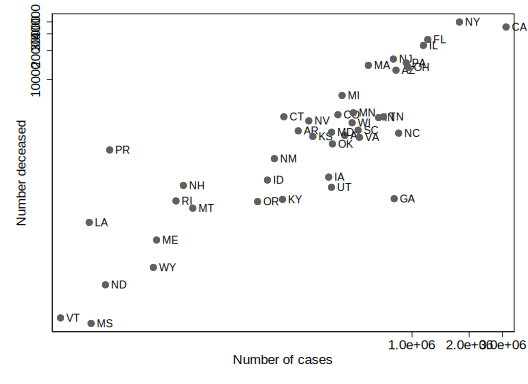

In [8]:
%%stata -qui
sc deceased cases, xscale(log) yscale(log) mlab(res_state) ytitle("Number deceased") xtitle("Number of cases")
drop if inlist(res_state,"PR","GA")

Finally, we see that nearly all of the IL cases and half of the RI cases with non-missing data are deaths; for now, we'll drop these two states too.

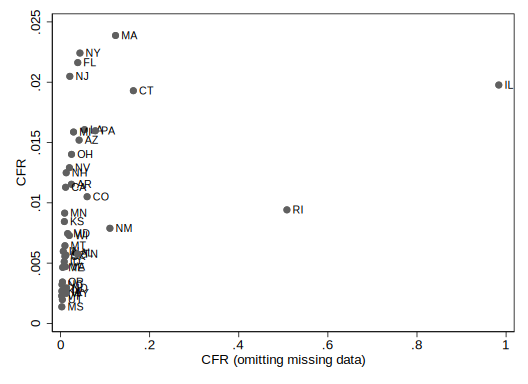

In [9]:
%%stata -qui
sc cfr cfr2 if res_state!="", mlab(res_state) ytitle("CFR") xtitle("CFR (omitting missing data)")
drop if inlist(res_state,"IL","RI")

With these states removed, we have 38 remaining; these represent 19,296,398 total cases and 235,635 deaths. The resulting CFR is 2.0% with a lower bound of 1.2% (as compared to the 2.3% and 1.2% obtained above).

In [10]:
%%stata -qui
gen cases_nonmiss = cases - death_miss
noi total deceased cases_nonmiss cases, cformat("%8.0f")
noi ratio cfr: deceased / cases_nonmiss
noi ratio cfr: deceased / cases


Total estimation                             Number of obs = 38

---------------------------------------------------------------
              |      Total   Std. err.     [95% conf. interval]
--------------+------------------------------------------------
     deceased |     235635      58258        117593      353677
cases_nonmiss |   11661626    3263993       5048149    18275103
        cases |   19296398    3552551      12098246    26494550
---------------------------------------------------------------

Ratio estimation                            Number of obs = 38

          cfr: deceased/cases_nonmiss

--------------------------------------------------------------
             |             Linearized
             |      Ratio   std. err.     [95% conf. interval]
-------------+------------------------------------------------
         cfr |    .020206   .0039585      .0121854    .0282266
--------------------------------------------------------------

Ratio estimation            

### CFR by Race/Ethnicity

Filter out problematic states identified above, and save the dataset for use in plotting later on.

In [11]:
%%stata -qui
cwf default
frlink m:1 res_state, frame(states)
keep if !mi(states)
cap mkdir tmp
save tmp/cdc_cleaned, replace

Here we calculate the CFR separately by ethnic group. This yields a risk ratio for Blacks compared to Whites of 2.64/3.36 = 0.79, and for Latinos compared to Whites of 2.26/3.36 = 0.67.

In [12]:
%stata tab deceased ethgrp if !death_miss, col nokey m


           |                         ethgrp
  deceased |         1          2          3          4          . |     Total
-----------+-------------------------------------------------------+----------
         0 | 3,822,995    839,088  1,132,122    843,293  4,788,493 |11,425,991 
           |     96.64      97.36      97.74      98.70      99.11 |     97.98 
-----------+-------------------------------------------------------+----------
         1 |   132,822     22,735     26,191     11,074     42,813 |   235,635 
           |      3.36       2.64       2.26       1.30       0.89 |      2.02 
-----------+-------------------------------------------------------+----------
     Total | 3,955,817    861,823  1,158,313    854,367  4,831,306 |11,661,626 
           |    100.00     100.00     100.00     100.00     100.00 |    100.00 


We can do slightly better by using only those states for each comparison that include deaths from both groups. This yields ratios of 0.73 and 0.48, as compared to 0.79 and 0.67 above.

In [13]:
%%stata -qui
egen byte b = total(deceased & ethgrp==2), by(res_state)
egen byte l = total(deceased & ethgrp==3), by(res_state)
mean deceased if !death_miss & inlist(ethgrp,1,2) & b, over(ethgrp)
noi di "Black versus White: " %4.2f _b[c.deceased@2.ethgrp]/_b[c.deceased@1.ethgrp]
mean deceased if !death_miss & inlist(ethgrp,1,3) & l, over(ethgrp)
noi di "Latino versus White: " %4.2f _b[c.deceased@3.ethgrp]/_b[c.deceased@1.ethgrp]

Black versus White: 0.73
Latino versus White: 0.48



Before going on, let's take a quick look at the distribution of ``age_group`` and calculate the CFRs within each age group. Out of the 11.7 million cases with reported mortality status, the large majority (6.3 million) are 18–49, while the smallest group are those 65+ (1.6 million). The CFRs are 0.1%, 0.8% and 13.5% among those aged 18–49, 50–54 and 65+, respectively; among the subset of 6 million cases with non-missing information for race/ethnnicity, the corresponding CFRs are 0.1%, 1.0% and 17.3%.

As we can see from the third table below, the age distribution of cases differs substantially between ethnic groups, with a smaller proportion of minority cases being in the oldest age group than non-minority cases. Given the huge differences in CFR by age, we clearly need to adjust for age when comparing CFRs across ethnic groups. We return to this in the section [CFR Ratios Comparing Racial/Ethnic Groups, Separately by Age Group](#CFR-Ratios-Comparing-Racial/Ethnic-Groups,-Separately-by-Age-Group) below.

In [14]:
%%stata -qui
replace age_group = "Missing" if age_group=="nan"
noi tab deceased age_group if !death_miss, col nokey m
noi tab deceased age_group if !death_miss & inlist(ethgrp,1,2,3), col nokey m
noi table ethgrp age_group if !death_miss, statistic(sum deceased) statistic(count deceased)


           |                       age_group
  deceased | 0 - 17 ..  18 to 4..  50 to 6..  65+ years    Missing |     Total
-----------+-------------------------------------------------------+----------
         0 | 1,327,892  6,334,981  2,298,016  1,367,319     97,783 |11,425,991 
           |    100.00      99.94      99.19      86.52      99.86 |     97.98 
-----------+-------------------------------------------------------+----------
         1 |         0      3,728     18,689    213,077        141 |   235,635 
           |      0.00       0.06       0.81      13.48       0.14 |      2.02 
-----------+-------------------------------------------------------+----------
     Total | 1,327,892  6,338,709  2,316,705  1,580,396     97,924 |11,661,626 
           |    100.00     100.00     100.00     100.00     100.00 |    100.00 

           |                       age_group
  deceased | 0 - 17 ..  18 to 4..  50 to 6..  65+ years    Missing |     Total
-----------+---------------------

### CFR Ratios Comparing Racial/Ethnic Groups, Stratified by State

Even when restricting our comparisons to states that include deaths from both groups, differences in the CFR across states combined with differences in their racial/ethnic composition may bias our comparisons. To address this, we need to stratify by state. We start by aggregating counts by state, race/ethnicity, and age group.

In [15]:
%%stata -qui
keep if inlist(ethgrp,1,2,3) & !death_miss
contract deceased res_state ethgrp age_group, zero freq(n)

We'll treat this as a meta-analysis; to use Stata's meta-analysis routines, we have to reshape to wide format.

In [16]:
%%stata -qui
frame copy default all_ages
cwf all_ages
egen m = total(n), by(deceased res_state ethgrp)
drop age_group n
duplicates drop
reshape wide m, i(res_state deceased) j(ethgrp)
reshape wide m1 m2 m3, i(res_state) j(deceased)

First, we'll estimate the CFR ratio comparing Black to White. As above, we include only those states that reported deaths among Blacks.

In [17]:
%%stata -qui
meta esize m21 m20 m11 m10, esize(lnrratio) random(dlaird) studylabel(res_state)
noi meta summarize if m11 & m21, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =     26
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.5928
                                                    I2 (%) =   99.73
                                                        H2 =  375.58

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AL |          0.542       0.494       0.595      3.91
               AR |          0.306       0.265       0.353      3.89
               AZ |          0.314       0.273       0.360      3.90
               CA |          0.672       0.640       0.706      3.92
               CO |          0.181       0.134       0

Next, we'll estimate the CFR ratio comparing Latinx to White.

In [18]:
%%stata -qui
meta esize m31 m30 m11 m10, esize(lnrratio) random(dlaird) studylabel(res_state)
noi meta summarize if m31 & m31, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =     14
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.2815
                                                    I2 (%) =   99.66
                                                        H2 =  295.11

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AZ |          0.708       0.680       0.737      7.59
               CA |          0.734       0.716       0.753      7.59
               CO |          0.037       0.029       0.048      7.18
               CT |          0.111       0.094       0.132      7.40
               FL |          0.477       0.463       0

### CFR Ratios Comparing Racial/Ethnic Groups, Separately by Age Group

Now we'll repeat the analyses in the section above, separately by age group. Once again, we start by reshaping so we can use Stata's meta-analysis routines.

In [19]:
%%stata -qui
cwf default
reshape wide n, i(res_state age_group deceased) j(ethgrp)
reshape wide n1 n2 n3, i(res_state age_group) j(deceased)

CFR ratio comparing Black to White, ages 18-49:

In [20]:
%%stata -qui
meta esize n21 n20 n11 n10, esize(lnrratio) random(dlaird) studylabel(res_state)
noi meta summarize if age_group=="18 to 49 years" & n11 & n21, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =      2
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  3.0032
                                                    I2 (%) =   97.89
                                                        H2 =   47.48

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               CA |          1.119       0.587       2.132     49.29
               NY |         13.318      10.032      17.682     50.71
------------------+-------------------------------------------------
       exp(theta) |          3.929       0.347      44.499
----------------------------------------------------------------

CFR ratio comparing Black to White, ages 50-64. Because the risk ratio for TN is so high, we recompute without TN to evaluate its impact on the result.

In [21]:
%%stata -qui
noi meta summarize if age_group=="50 to 64 years" & n11 & n21, rr
noi meta summarize if age_group=="50 to 64 years" & n11 & n21 & res_state!="TN", rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =     12
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.8529
                                                    I2 (%) =   98.76
                                                        H2 =   80.83

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AR |          1.722       0.890       3.330      7.67
               AZ |          0.603       0.411       0.884      8.32
               CA |          1.492       1.296       1.717      8.64
               CT |          0.498       0.288       0.861      7.96
               FL |          4.768       4.054       5

CFR ratio comparing Black to White, ages 65+:

In [22]:
%stata noi meta summarize if age_group=="65+ years" & n11 & n21, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =     26
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.2203
                                                    I2 (%) =   99.37
                                                        H2 =  159.80

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AL |          0.889       0.813       0.972      3.99
               AR |          0.711       0.619       0.817      3.94
               AZ |          0.959       0.840       1.095      3.95
               CA |          0.945       0.898       0.994      4.02
               CO |          0.569       0.438       0

CFR ratio comparing Latino to White, ages 18-49:

In [23]:
%%stata -qui
meta esize n31 n30 n11 n10, esize(lnrratio) random(dlaird) studylabel(res_state)
noi meta summarize if age_group=="18 to 49 years" & n11 & n31, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =      3
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.4816
                                                    I2 (%) =   95.50
                                                        H2 =   22.24

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AZ |          4.514       3.427       5.944     33.54
               CA |         17.302      12.632      23.698     33.14
               NY |         12.108       8.998      16.293     33.32
------------------+-------------------------------------------------
       exp(theta) |          9.789       4.382      21

CFR ratio comparing Latino to White, ages 50-64:

In [24]:
%stata meta summarize if age_group=="50 to 64 years" & n11 & n31, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =      9
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.1624
                                                    I2 (%) =   96.60
                                                        H2 =   29.39

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AZ |          3.049       2.752       3.378     12.86
               CA |          3.709       3.426       4.015     12.95
               CT |          0.306       0.163       0.573      8.01
               FL |          4.075       3.502       4.741     12.62
               NJ |          2.156       1.869       2

CFR ratio comparing Latino to White, ages 65+:

In [25]:
%stata meta summarize if age_group=="65+ years" & n11 & n31, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: res_state

Meta-analysis summary                     Number of studies =     13
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.1536
                                                    I2 (%) =   99.51
                                                        H2 =  205.41

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AZ |          1.474       1.416       1.534      8.24
               CA |          1.457       1.419       1.496      8.25
               CO |          0.336       0.267       0.424      7.57
               CT |          0.626       0.537       0.729      7.94
               FL |          1.044       1.015       1

## CTP Data

Now we'll turn to the data from the COVID Tracking Project (CTP), downloaded from [their site](https://covidtracking.com/race/dashboard) on 2021-10-31. Unlike the CDC data, the CTP data are cumulative counts of cases and deaths. We will work with the counts from the last day in February 2021 (i.e., the last full month of data before the project shut down).

In [26]:
df = pd.read_csv('data/ctp/CRDT Data - CRDT.csv')
df['Cases_Other'] = df[['Cases_Asian','Cases_AIAN','Cases_NHPI','Cases_Multiracial','Cases_Other']].sum(axis=1)
df['Deaths_Other'] = df[['Deaths_Asian','Deaths_AIAN','Deaths_NHPI','Deaths_Multiracial','Deaths_Other']].sum(axis=1)
df['Cases_Missing'] = df.Cases_Total - df[['Cases_White','Cases_Black','Cases_Latinx','Cases_Other']].sum(axis=1)
df['Deaths_Missing'] = df.Deaths_Total - df[['Deaths_White','Deaths_Black','Deaths_Latinx','Deaths_Other']].sum(axis=1)
df = df.loc[df.Date==20210228,['Date','State','Cases_Total','Deaths_Total','Cases_White','Deaths_White','Cases_Black',
                               'Deaths_Black','Cases_Latinx','Deaths_Latinx','Cases_Other','Deaths_Other','Cases_Missing',
                               'Deaths_Missing']]
df.head()

,Date,State,Cases_Total,Deaths_Total,Cases_White,Deaths_White,Cases_Black,Deaths_Black,Cases_Latinx,Deaths_Latinx,Cases_Other,Deaths_Other,Cases_Missing,Deaths_Missing
112,20210228,AK,58293.0,290.0,17991.0,122.0,1481.0,9.0,NaN,NaN,27442.0,154.0,11379.0,5.0
113,20210228,AL,493252.0,9929.0,158420.0,4625.0,81782.0,2168.0,NaN,NaN,40046.0,318.0,213004.0,2818.0
114,20210228,AR,322415.0,5243.0,205690.0,4113.0,50508.0,773.0,NaN,NaN,25410.0,321.0,40807.0,36.0
115,20210228,AS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
116,20210228,AZ,816782.0,15980.0,304962.0,7874.0,25464.0,423.0,242379.0,4587.0,98718.0,2002.0,145259.0,1094.0


### CFRs, Both Overall and by Race/Ethnicity

Compute CFRs, both overall and separately by racial/ethnic group.

In [27]:
%%stata -d df -force -qui
foreach grp in Total White Black Latinx Other Missing {
    count if mi(Cases_`grp',Deaths_`grp')
    noi di as text _n "Group: `grp' (`r(N)' missing)"
    if inrange(r(N),1,9) noi table State if mi(Cases_`grp',Deaths_`grp')
    noi total Cases_`grp' if !mi(Cases_`grp',Deaths_`grp'), cformat(%8.0f)
    noi total Deaths_`grp' if !mi(Cases_`grp',Deaths_`grp'), cformat(%8.0f)
    noi ratio CFR: Deaths_`grp' / Cases_`grp' if !mi(Cases_`grp',Deaths_`grp')
}


Group: Total (1 missing)

--------------------
        |  Frequency
--------+-----------
State   |           
  AS    |          1
  Total |          1
--------------------

Total estimation                            Number of obs = 55

--------------------------------------------------------------
             |      Total   Std. err.     [95% conf. interval]
-------------+------------------------------------------------
 Cases_Total |   28443555    4764867      18890571    37996539
--------------------------------------------------------------

Total estimation                            Number of obs = 55

--------------------------------------------------------------
             |      Total   Std. err.     [95% conf. interval]
-------------+------------------------------------------------
Deaths_Total |     512627      86818        338566      686688
--------------------------------------------------------------

Ratio estimation                            Number of obs = 55

 

### CFR Ratios Comparing Racial/Ethnic Groups

Before computing the CFR ratios we need to reshape the data to long form.

In [28]:
%%stata -qui
drop *_Total *_Other *_Missing
reshape long Deaths_ Cases_, i(State) j(ethgrp) string
gen n0 = Cases_ - Deaths_
ren Deaths_ n1
keep State ethgrp n0 n1
reshape long n, i(State ethgrp) j(deceased)
keep if inlist(ethgrp,"Black","Latinx","Total","White")
gen byte minority = inlist(ethgrp,"Black","Latinx") if ethgrp!="Total"

NY has no case counts by race/ethnicity, so we'll drop it.

In [29]:
%%stata -qui
noi li if State=="NY"
drop if State=="NY"


     +----------------------------------------------+
     | State   ethgrp   deceased       n   minority |
     |----------------------------------------------|
223. |    NY    Black          0       .          1 |
224. |    NY    Black          1    9448          1 |
225. |    NY   Latinx          0       .          1 |
226. |    NY   Latinx          1    9816          1 |
227. |    NY    White          0       .          0 |
     |----------------------------------------------|
228. |    NY    White          1   16920          0 |
     +----------------------------------------------+



Calculate CFR ratio comparing Black to White, stratified by state. As above, we include only those states that reported deaths among Blacks.

In [30]:
%%stata -qui
drop minority
reshape wide n, i(State deceased) j(ethgrp) string
reshape wide nBlack nLatinx nWhite, i(State) j(deceased)
meta esize nBlack1 nBlack0 nWhite1 nWhite0, esize(lnrratio) random(dlaird) studylabel(State)
noi meta summarize if nWhite1 & nBlack1, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: State

Meta-analysis summary                     Number of studies =     49
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.1142
                                                    I2 (%) =   99.12
                                                        H2 =  113.15

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AK |          0.896       0.456       1.760      1.18
               AL |          0.908       0.863       0.955      2.39
               AR |          0.765       0.709       0.826      2.37
               AZ |          0.643       0.584       0.709      2.35
               CA |          0.971       0.936       1.009

CFR ratio comparing Latinx to White, stratified by state

In [31]:
%%stata -qui
meta esize nLatinx1 nLatinx0 nWhite1 nWhite0, esize(lnrratio) random(dlaird) studylabel(State)
noi meta summarize if nWhite1 & nLatinx1, rr


  Effect-size label: Log risk-ratio
        Effect size: _meta_es
          Std. err.: _meta_se
        Study label: State

Meta-analysis summary                     Number of studies =     23
Random-effects model                      Heterogeneity:
Method: DerSimonian–Laird                             tau2 =  0.2575
                                                    I2 (%) =   99.81
                                                        H2 =  520.63

--------------------------------------------------------------------
            Study |     Risk ratio    [95% conf. interval]  % weight
------------------+-------------------------------------------------
               AZ |          0.733       0.707       0.760      4.46
               CA |          0.531       0.520       0.541      4.46
               CO |          0.471       0.441       0.502      4.44
               CT |          0.292       0.271       0.315      4.44
               DE |          0.223       0.177       0.281